In [5]:
import sys
from outletsBiasRatings import outletsBiasRatingsAllSides,outletAbbreviationToFullName
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import time
from joblib import Parallel, delayed
from scipy import stats
from statsmodels.stats.multitest import multipletests
import chow_test

In [6]:
outletsBiasRatings = outletsBiasRatingsAllSides
outlets = list(outletsBiasRatings.keys())
startYear = 2000
endYear = 2019

emotions=['anger','disgust','fear','joy','sadness', 'neutral'] #j-hartmann/emotion-english-distilroberta-base #No surprise category since model underperforms for that category according to ground truth of human annotations 
years=[str(year) for year in range(startYear,endYear+1)]

print(years)
print(len(outlets))
print(outlets)

['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
47
['alternet', 'democracynow', 'db', 'hp', 'theintercept', 'jacobin', 'motherjones', 'thenewyorker', 'thenation', 'slate', 'vox', 'cnn', 'nyt', 'abcnews', 'theatlantic', 'buzzfeed', 'cbs', 'economist', 'guardian', 'nbcnews', 'politico', 'timemagazine', 'wp', 'npr', 'ap', 'bbc', 'bloomberg', 'csm', 'reuters', 'thehill', 'usatoday', 'wsj', 'reason', 'we', 'wt', 'fox', 'americanspectator', 'bre', 'theblaze', 'cbn', 'dailycaller', 'dailymail', 'dailywire', 'thefederalist', 'nationalreview', 'nyp', 'newsmax']


## Load emotions

In [7]:
with open('emotionsDictionary.pickle', 'rb') as handle:
    emotionsDictionary = pickle.load(handle)

In [8]:
def getMatrixOfEmotionTimeSeriesInOutlets(emotionsDictionary,emotion,outlets,startYear,endYear):
    years=[str(year) for year in range(startYear,endYear+1)]
    m=np.zeros([len(outlets),len(years)])
    for outletIndex, outlet in enumerate(outlets):
        for yearIndex, year in enumerate(years):
            try:
                m[outletIndex,yearIndex]=emotionsDictionary[outlet][year][emotion]
            except KeyError:
                m[outletIndex,yearIndex]=np.nan
    return m

In [9]:
def normalizeWordMatrix(m):
    maximumInEachRow = np.nanmax(m, axis=1)  # Get max frequency for each outlet
    normalized_m = m / maximumInEachRow.reshape(-1,1)  # Divide each frequency by maximum frequency in the outlet time series
    return normalized_m

In [10]:
def getAverageEmotionAcrossOutlets(emotionsDictionary,emotion,outlets,startYear,endYear,normalize=False,z=1.96):
    m=getMatrixOfEmotionTimeSeriesInOutlets(emotionsDictionary,emotion,outlets,startYear,endYear)    
    
    if normalize == True:
        m = normalizeWordMatrix(m)
    xYears = [item for item in list(range(startYear, endYear + 1))]

    n = np.sum(~np.isnan(m), axis=0)  # number of obs in each time interval

    # Aggregate the metrics of several outlets
    mAverage = np.nanmean(m, axis=0)  # Proper way when nan values are present

    # Confidence intervals
    mStd = np.nanstd(m, axis=0)
    #     mStd = np.nanstd(m,axis=0)

    z = 1.96  # for a 95% C
    #     z = 2.58 # for a 99% C
    #     z = 3.291 # for a 99.9% C
    CI = z * (mStd / np.sqrt(n))

    return (xYears, mAverage, CI)
    

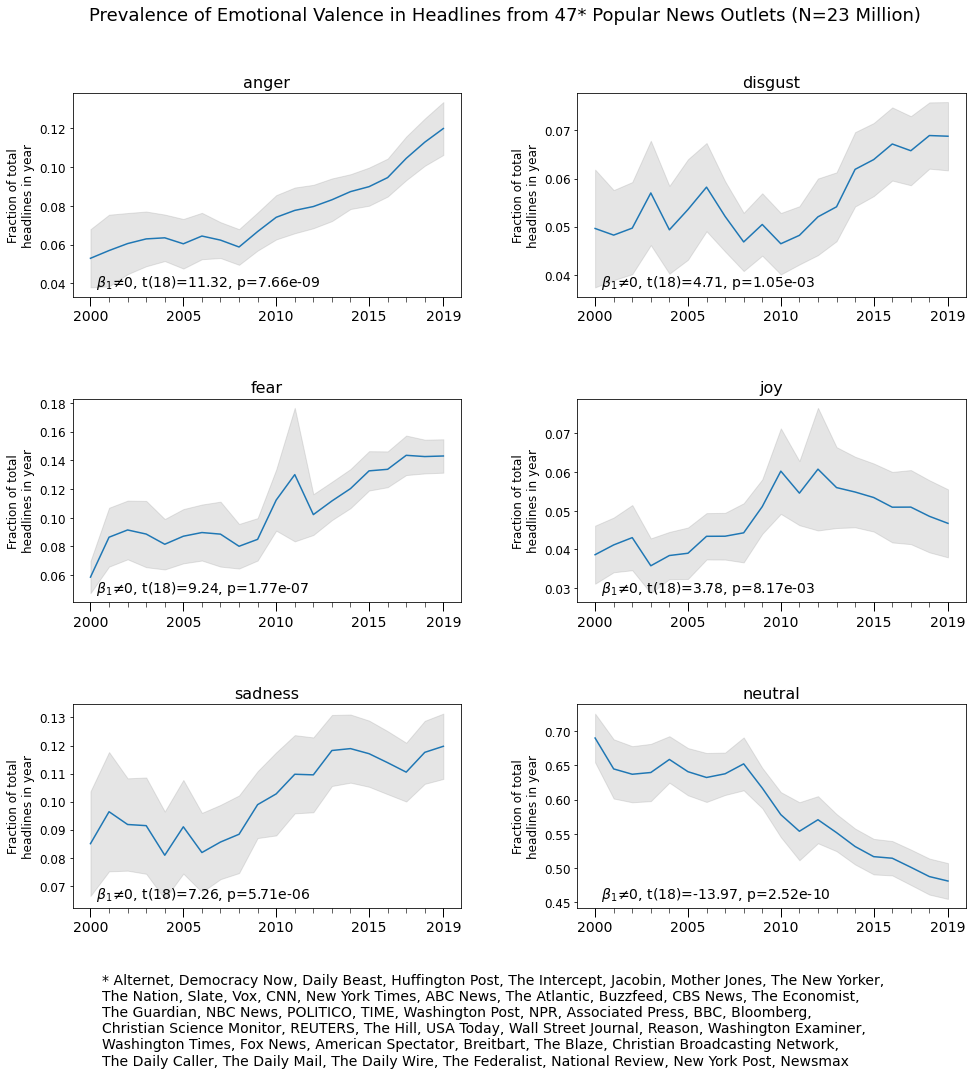

In [11]:
outlets = list(outletsBiasRatings.keys())

startYear=2000
endYear= 2019
years=[str(year) for year in range(startYear,endYear+1)]
yearsInts=[int(year) for year in years]
df=len(yearsInts)-2 #
outletColor = ['b','r','y','k','purple','pink','cyan','orange']

fig, axs = plt.subplots(3, 2,figsize=(16,15)) 
for emotionIndex, emotion in enumerate(emotions):
    row=emotionIndex//2
    column=emotionIndex%2    

    years,mAverage, CI = getAverageEmotionAcrossOutlets(emotionsDictionary,emotion,outlets,startYear,endYear,normalize=False,z=1.96)

    axs[row, column].plot(years,mAverage,label="Average of 47 news outlets")
    axs[row, column].set_ylabel("Fraction of total\nheadlines in year",fontsize=12)
    axs[row, column].fill_between(years, mAverage+CI, mAverage-CI,color='grey', alpha=.2)
    
    axs[row, column].xaxis.set_major_locator(MultipleLocator(5))
    axs[row, column].xaxis.set_minor_locator(MultipleLocator(1))
    axs[row, column].tick_params(axis="x", which="major", length=9,width=1)        
    axs[row, column].tick_params(axis="x", which="minor", length=5)     
    
    #Regression slope test 
    slope, intercept, r_value, p_value, std_err=stats.linregress(yearsInts,mAverage)
    p_value=multipletests([p_value]*len(emotions),method="bonferroni")[1][0] #Bonferroni Correction
    s=r' $ \beta_1 \ne 0 $' +f", t({df})="+"{0:.2f}".format(slope/std_err)+", p={0:.2e}".format(p_value)
    plt.text(0.05,0.05,s,transform=axs[row, column].transAxes,fontsize=14)    
    
    axs[row, column].tick_params(axis='y',labelsize=12)
    axs[row, column].set_xticks(years[::5]+[2019])
    axs[row, column].set_xticklabels(years[::5]+[2019], rotation=0,fontsize=14 )
    
    axs[row, column].set_title(f'{emotion}',fontsize=16)
    
s = """* Alternet, Democracy Now, Daily Beast, Huffington Post, The Intercept, Jacobin, Mother Jones, The New Yorker,\nThe Nation, Slate, Vox, CNN, New York Times, ABC News, The Atlantic, Buzzfeed, CBS News, The Economist,\nThe Guardian, NBC News, POLITICO, TIME, Washington Post, NPR, Associated Press, BBC, Bloomberg,\nChristian Science Monitor, REUTERS, The Hill, USA Today, Wall Street Journal, Reason, Washington Examiner,\nWashington Times, Fox News, American Spectator, Breitbart, The Blaze, Christian Broadcasting Network,\nThe Daily Caller, The Daily Mail, The Daily Wire, The Federalist, National Review, New York Post, Newsmax"""
plt.figtext(0.15,-0.02,s,fontsize=14)

plt.subplots_adjust(hspace = 0.5,wspace = 0.3)      
figureTitle="Prevalence of Emotional Valence in Headlines from 47* Popular News Outlets (N=23 Million)"
st=fig.suptitle(figureTitle, y=0.96,fontsize=18)    

fig.savefig('../manuscript/figures/2-2emotionalityOfHeadlinesWithDistilroberta.png',dpi=400,bbox_inches='tight',pad_inches=0)#High-resolution    

In [18]:
def testChow(emotion,yearBreak):
    years,mAverage, CI = getAverageEmotionAcrossOutlets(emotionsDictionary,emotion,outlets,startYear,endYear,normalize=False,z=1.96)
    yearsStr=[str(year) for year in years]
    y=pd.DataFrame(mAverage,index=yearsStr)
    x=pd.DataFrame(years, index=y.index)
    x1=x[:yearBreak].values.flatten()
    y1=y[:yearBreak].values.flatten()
    x2=x[yearBreak:].values.flatten()
    y2=y[yearBreak:].values.flatten()
    print(emotion,chow_test.f_value(y1, x1, y2, x2),chow_test.p_value(y1, x1, y2, x2))

In [19]:
yearBreak='2009'
for emotion in emotions:    
    testChow(emotion,yearBreak)

anger [31.83381897] 1.7859588086131475e-06
disgust [14.32304631] 0.0002258838443809347
fear [3.88283551] 0.04084039973241693
joy [18.37779054] 5.6262051700429004e-05
sadness [6.74554033] 0.006971831615138917
neutral [11.62635415] 0.0006577448089879798


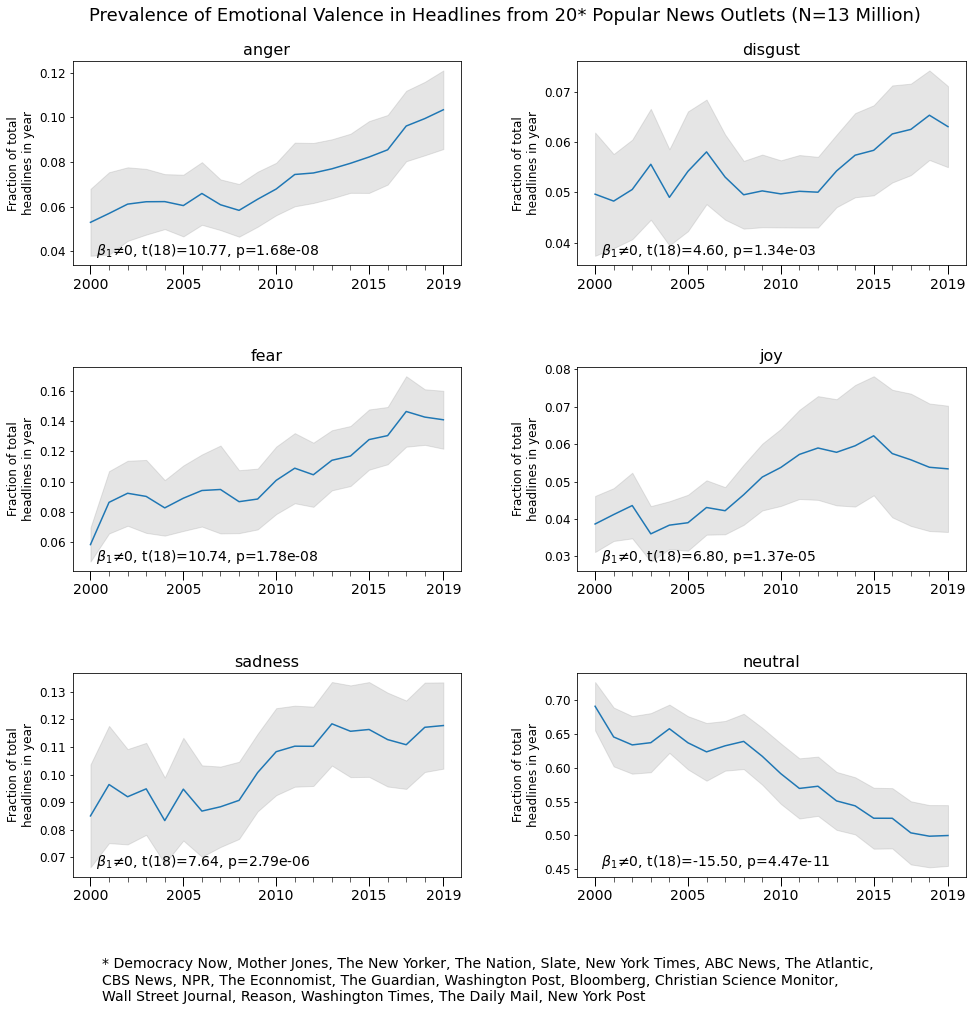

In [10]:
#outlets with data since 2000
outlets = ['nyp','dailymail','wt','wsj','csm','bloomberg','wp','guardian','economist','cbs','nyt','slate',
          'thenewyorker','thenation','theatlantic','reason','npr','abcnews','democracynow','motherjones'
          ]

startYear=2000
endYear= 2019
years=[str(year) for year in range(startYear,endYear+1)]
yearsInts=[int(year) for year in years]
df=len(yearsInts)-2 
outletColor = ['b','r','y','k','purple','pink','cyan','orange']

fig, axs = plt.subplots(3, 2,figsize=(16,15)) 
for emotionIndex, emotion in enumerate(emotions):
    row=emotionIndex//2
    column=emotionIndex%2    

    years,mAverage, CI = getAverageEmotionAcrossOutlets(emotionsDictionary,emotion,outlets,startYear,endYear,normalize=False,z=1.96)
    axs[row, column].plot(years,mAverage,label="Average of 47 news outlets")
    axs[row, column].set_ylabel("Fraction of total\nheadlines in year",fontsize=12)
    axs[row, column].fill_between(years, mAverage+CI, mAverage-CI,color='grey', alpha=.2)
    
    axs[row, column].xaxis.set_major_locator(MultipleLocator(5))
    axs[row, column].xaxis.set_minor_locator(MultipleLocator(1))
    axs[row, column].tick_params(axis="x", which="major", length=9,width=1)        
    axs[row, column].tick_params(axis="x", which="minor", length=5)     
    
    #Regression slope test 
    slope, intercept, r_value, p_value, std_err=stats.linregress(yearsInts,mAverage)
    p_value=multipletests([p_value]*len(emotions),method="bonferroni")[1][0] #Bonferroni Correction
    s=r' $ \beta_1 \ne 0 $' +f", t({df})="+"{0:.2f}".format(slope/std_err)+", p={0:.2e}".format(p_value)
    plt.text(0.05,0.05,s,transform=axs[row, column].transAxes,fontsize=14)    
    
    axs[row, column].tick_params(axis='y',labelsize=12)
    axs[row, column].set_xticks(years[::5]+[2019])
    axs[row, column].set_xticklabels(years[::5]+[2019], rotation=0,fontsize=14 )
    
    axs[row, column].set_title(f'{emotion}',fontsize=16)
    
s = """* Democracy Now, Mother Jones, The New Yorker, The Nation, Slate, New York Times, ABC News, The Atlantic,\nCBS News, NPR, The Econnomist, The Guardian, Washington Post, Bloomberg, Christian Science Monitor,\nWall Street Journal, Reason, Washington Times, The Daily Mail, New York Post"""
plt.figtext(0.15,0.01,s,fontsize=14)

plt.subplots_adjust(hspace = 0.5,wspace = 0.3)      
figureTitle="Prevalence of Emotional Valence in Headlines from 20* Popular News Outlets (N=13 Million)"
st=fig.suptitle(figureTitle, y=0.93,fontsize=18)    

fig.savefig('../manuscript/figures/sm/2-2emotionalityOfHeadlinesOnlyOutletsWithArticlesSince2000.png',dpi=400,bbox_inches='tight',pad_inches=0)#High-resolution    

In [15]:
def testChow(emotion,yearBreak):
    years,mAverage, CI = getAverageEmotionAcrossOutlets(emotionsDictionary,emotion,outlets,startYear,endYear,normalize=False,z=1.96)
    yearsStr=[str(year) for year in years]
    y=pd.DataFrame(mAverage,index=yearsStr)
    x=pd.DataFrame(years, index=y.index)
    x1=x[:yearBreak].values.flatten()
    y1=y[:yearBreak].values.flatten()
    x2=x[yearBreak:].values.flatten()
    y2=y[yearBreak:].values.flatten()
    print(emotion,chow_test.f_value(y1, x1, y2, x2),chow_test.p_value(y1, x1, y2, x2))

In [16]:
yearBreak='2009'
for emotion in emotions:    
    testChow(emotion,yearBreak)

anger [25.90953048] 6.8911471196824785e-06
disgust [10.94041872] 0.0008832083023611754
fear [5.94055631] 0.011055986790920664
joy [8.2030817] 0.0032084089730832904
sadness [6.3999064] 0.008472289282750952
neutral [8.11178096] 0.003361423267974074
